<a href="https://colab.research.google.com/github/vinnieOrdobas/myPortfolio/blob/master/dog_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## End-to-end Multi-class Dog Breed Classification

This notebook builds an end-to-end multi-class image classifier using TensorFlow 2.0 and TensorFlow Hub

## 1. Problem
Identifying the breed of a dog given an image of a dog

## 2. Data
The data we're using is from Kaggle's dog breed identification competition.
https://www.kaggle.com/c/dog-breed-identification/data

## 3. Evaluation

The evaluation is a file prediction probabilities for each dog breed of each test image.
https://www.kaggle.com/c/dog-breed-identification/overview/evaluation
## 4. Features

Some information about the data:

* We're dealing with images (unstructured data) so it's probably best we use deep learning/transfer learning.
* There are 120 breeds of dogs(this means there are 120 different classes).
* There are around 10,000+ images in the training set
* There are around 10,000+ images int he test set(these images have no labels, because we'll want predict them).


In [0]:
# Unzip the uploaded data into Google Drive
!unzip "/content/drive/My Drive/Colab Notebooks/data/dog-breed-identification.zip"

Streaming output truncated to the last 5000 lines.
  inflating: train/83bcff6b55ee179a7c123fa6103c377a.jpg  
  inflating: train/83be6d622ab74a5e7e08b53eb8fd566a.jpg  
  inflating: train/83c2d7419b0429b9fe953bc1b6cddbec.jpg  
  inflating: train/83cf7d7cd2a759a93e2ffd95bea9c6fb.jpg  
  inflating: train/83d405858f0931722ef21e8ac0adee4d.jpg  
  inflating: train/83d4125a4c3c7dc5956563276cb1cd74.jpg  
  inflating: train/83f0bb565b2186dbcc6a9d009cb26ff2.jpg  
  inflating: train/83fad0718581a696132c96c166472627.jpg  
  inflating: train/83fbbcc9a612e3f712b1ba199da61f20.jpg  
  inflating: train/8403d8936430c2f05ab7d74d23c2c0cb.jpg  
  inflating: train/8406d837b2d7fac1c3cd621abb4c4f9e.jpg  
  inflating: train/840b67d26e5e43f8eb6430f62d4ba1ac.jpg  
  inflating: train/840db91ba4600148f3dcb06ec419b421.jpg  
  inflating: train/840dbad5a691c22611d85b2488bf4cbb.jpg  
  inflating: train/8410ced9ebc1759a7ebce5c42bfb5222.jpg  
  inflating: train/841463629c4833816e216cbb041c2778.jpg  
  inflating: train/84

### Get our spacework ready
* Import TensorFlow 2.x
* Import TensorFlow Hub
* Make sure we're using a GPU


In [0]:
# Import TensorFlow into Colab
import tensorflow as tf
print("TF version:", tf.__version__)

TF version: 1.15.0


In [0]:
# Import TF 2.x
try:
  #%tensorflow_version only exists in Colab
  %tensorflow_version 2.x
except Exception:
    pass

In [0]:
# Import necessary tools
import tensorflow as tf
import tensorflow_hub as hub
print ("TF version:", tf.__version__)
print ("TF Hub version:",hub.__version__)

# Check for GPU availability
print("GPU","available (YESS!!!)") if tf.config.list_physical_devices("GPU") else ("not available :( ")

TF version: 2.2.0-rc1
TF Hub version: 0.7.0
GPU available (YESS!!!)


## Getting our data ready (turning into Tensors)
With all machine learning models, our data has to be in numerical format. So that's what we'll be doing first. Turning our images into Tensors (numerical representations).
Let's start by acessing our data and checking out the labels.


In [0]:
# Checkout the labels of our data
import pandas as pd
labels_csv = pd.read_csv("/content/labels.csv")

In [0]:
print(labels_csv.head())
print(labels_csv.describe())

                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever
                                      id               breed
count                              10222               10222
unique                             10222                 120
top     18b631157527e14b007e570175c921a3  scottish_deerhound
freq                                   1                 126


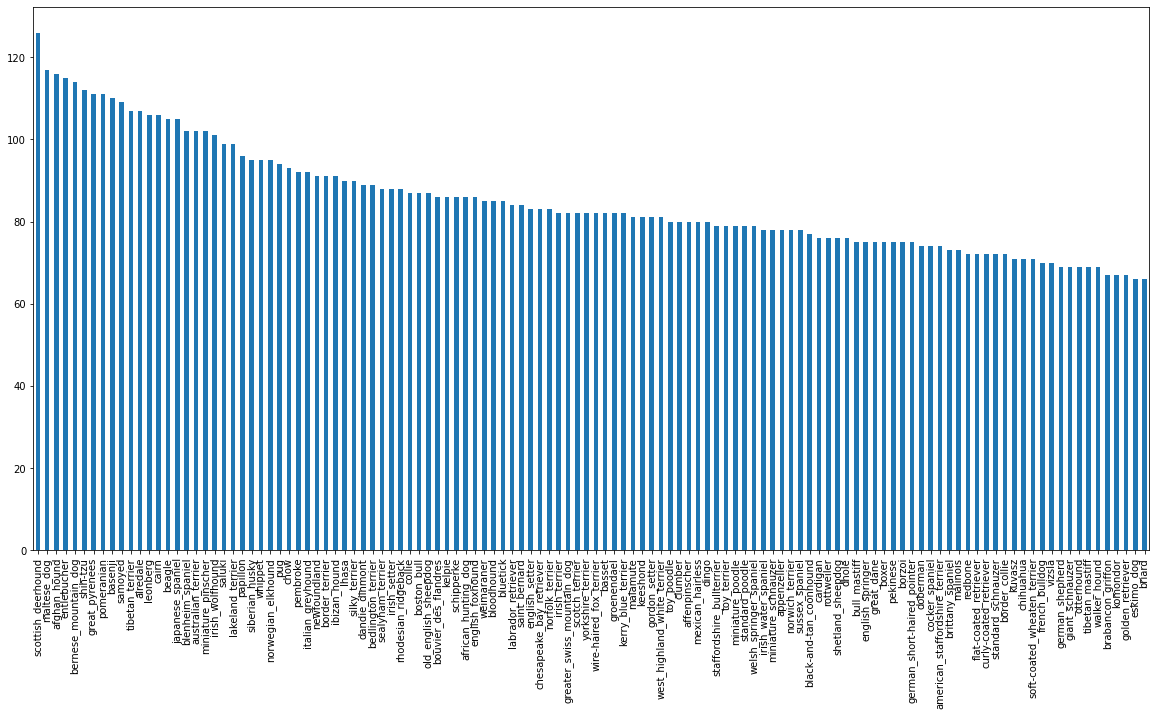

In [0]:
# How many images are there of each breed?
labels_csv['breed'].value_counts().plot.bar(figsize=(20,10))

In [0]:
labels_csv['breed'].value_counts().median()

82.0

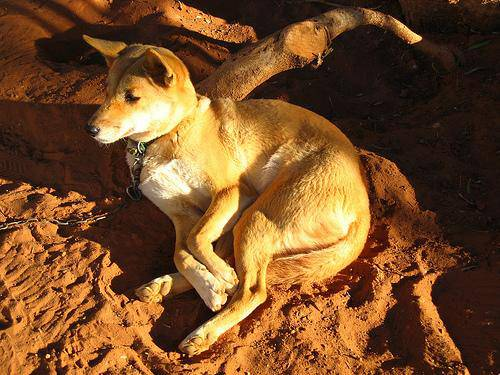

In [0]:
# Let's view an image
from IPython.display import Image
Image("/content/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg")

**Getting images and their labels**

Let's get a list of all of our file pathnames


In [0]:
# Create pathnames from image ID's
filenames = ["/content/train/"+ fname + ".jpg" for fname in labels_csv['id']]

# Check the first 10
filenames[:10]

['/content/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 '/content/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 '/content/train/001cdf01b096e06d78e9e5112d419397.jpg',
 '/content/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 '/content/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 '/content/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 '/content/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 '/content/train/002a283a315af96eaea0e28e7163b21b.jpg',
 '/content/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 '/content/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [0]:
# Check whether number of filenames matches number of actual image files
import os
if len(os.listdir("/content/train/")) == len(filenames):
  print("Filenames match actual amount of files. Proceed")
else:
    print("Filenames do not match actual amount of files. Check the target directory.")

Filenames match actual amount of files. Proceed


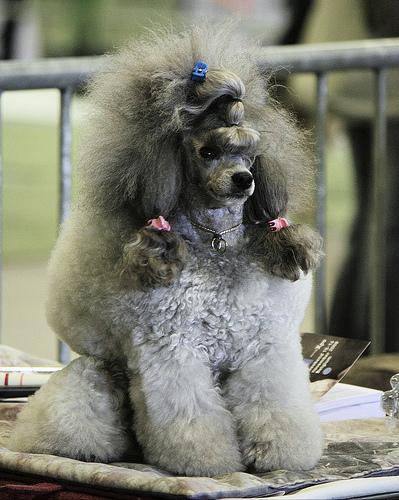

In [0]:
# One more check
Image(filenames[877])

In [0]:
labels_csv['breed'][877]

'miniature_poodle'

Since we've got our training image filepaths in a list, let's prepare our labels.

In [0]:
import numpy as np

labels = labels_csv['breed'].to_numpy()
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [0]:
# See if number of labels matches the number of filenames
if len(labels) == len(filenames):
  print("Number of labels matches number of filenames")
else:
  print("Number of labels does not match number of filenames, check data directories!")


Number of labels matches number of filenames


In [0]:
# Find the unique label values
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [0]:
# Turn a single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [0]:
# Turn every label into a boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [0]:
# Example: Turning boolean array into integers
print(labels[0]) #original label
print(np.where(unique_breeds == labels[0])) #index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # there will be a 1 where the sample label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


## Creating our own validation set

* Since the dataset from Kaggle doesn't come with a validation set, we're going to create our own

In [0]:
# Setup X & y variables
X= filenames
y=boolean_labels
len(y)

10222

We're going to start off experimenting with ~1000 images and increase as needed.

In [0]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000 #@param{type: "slider", min:1000, max:10000, step: 1000}

In [0]:
from sklearn.model_selection import train_test_split

# Split them into training and validation of total size NUM_IMAGES
X_train,X_val,y_train,y_val = train_test_split(X[:NUM_IMAGES],
                                               y[:NUM_IMAGES],
                                               test_size=0.2,
                                               random_state=42)


In [0]:
len(X_train),len(y_train),len(X_val),len(y_val)

(800, 800, 200, 200)

In [0]:
X_train[:5],y_train[:2]

(['/content/train/00bee065dcec471f26394855c5c2f3de.jpg',
  '/content/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  '/content/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  '/content/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  '/content/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, F

## Preprocessing Images (turning images into Tensors)

To preprocess our images into Tensors, we're going to write a function which does a few things:
1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to a variable `image`
3. Turn our `image` (a jpg) into Tensors
4. Normalize our image(convert colour channel values from 0-255 to 0-1).
5. Resize the `image` to be a shape (224,224)
6. Return the modified `image`

Before we do, let's see what importing an image looks like

In [0]:
# Convert image to NumPy array
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

In [0]:
# Turn image into a tensor
tf.constant(image)[:2]


<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)>

Now we've seen what an image looks like as a Tensor, let's make a function to preprocess them

In [0]:
# Define image size
IMG_SIZE = 224

# Create a function for preprocessing images
def process_image(image_path,img_size = IMG_SIZE):
  """
  Takes an image file path and turns the image into a Tensor.
  """
  # Read in an image file
  image = tf.io.read_file(image_path)
  # Turn the jpeg image into numerical Tensor with 3 colour channels(Red,Green, Blue)
  image = tf.image.decode_jpeg(image, channels = 3)
  # Convert the colour channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired value(224,224)
  image = tf.image.resize(image,size=[IMG_SIZE,IMG_SIZE])

  return image

## Turning our data into batches

Let's save some time and computational power with batches.

In order to use TensorFlow effectively, we need our data in the form of Tensor tuples which look like this:
`(image,label)`.


In [0]:
# Create a simple function to return a tuple(image,label)
def get_image_label(image_path,label):
  """
  Takes an image file path name and the associated label,
  processes the image and returns a tuple of (image,label)
  """
  image = process_image(image_path)
  return image,label

In [0]:
# Demo of the above
(process_image(X[77]),y[77])

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.25621685, 0.2758247 , 0.2875894 ],
         [0.26963976, 0.2892476 , 0.3010123 ],
         [0.26181838, 0.28142622, 0.29319093],
         ...,
         [0.28203785, 0.26698178, 0.22352943],
         [0.25941882, 0.25157568, 0.19940475],
         [0.26817232, 0.2603292 , 0.20150568]],
 
        [[0.33034942, 0.34995726, 0.36172196],
         [0.3683063 , 0.38791415, 0.39967886],
         [0.30906886, 0.3286767 , 0.3404414 ],
         ...,
         [0.27842787, 0.26337183, 0.21991946],
         [0.2594626 , 0.25161946, 0.19944851],
         [0.2682161 , 0.26037297, 0.20154944]],
 
        [[0.2370238 , 0.25663164, 0.26839635],
         [0.18850322, 0.20811108, 0.21987578],
         [0.250397  , 0.27000484, 0.28176954],
         ...,
         [0.2756449 , 0.26058882, 0.21713647],
         [0.26334038, 0.25549725, 0.20332631],
         [0.2720939 , 0.26425076, 0.20542724]],
 
        ...,
 
        [[0.18263985, 0.19440456

Now we've got a way to turn our data into tuples of Tensors in the form: `(image,label)`,let's make a function to turn all of our data(X & y) into batches

In [0]:
# Define the batch size(32)
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(X,y=None, batch_size = BATCH_SIZE, valid_data= False, test_data=False):
  """
  Creates batches of data out of image(X)and label(y) pairs.
  Shuffles the data if it's training data but doesn't shuffle if it's validation data.
  Also accepts test data as input (no labels).
  """
  # If the data is a test dataset, we probably don't have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices(tf.constant(X)) #only filepaths(no labels)
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  # If the data is valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),#filepaths
                                               tf.constant(y)))#labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch
  else:
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    #Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(X))

    #Create (image,label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the training data into batches
    data_batch = data.batch(BATCH_SIZE)
  
  return data_batch



In [0]:
# Create training and validation data batches
train_data = create_data_batches(X_train,y_train)
val_data = create_data_batches(X_val,y_val,valid_data = True)

Creating training data batches...
Creating validation data batches...


In [0]:
# Check out the different attributes of our data batches
train_data.element_spec,val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualizing Data Batches

Our data is now in batches, however, these can be a little hard to understand/comprehend, let's visualize them!

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
from google.colab.patches import cv2_imshow

# Create a function for viewing images in a data batch

def show_25_images(images, labels):
  """
  Displays a plot of 25 images and their labels from a data batch.
  """
  # Setup the figure
  plt.figure(figsize=(10,10))
  # Loop through 25 (for displaying 25 images)
  for i in range(25):
    # Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5,5,i+1)
    # Display an image
    plt.imshow(image[i])
    # Add the image label
    plt.title(unique_breeds[labels[i].argmax()])
    # Turn the grid lines off
    plt.axis("OFF")


In [0]:
train_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [0]:
train_images, train_labels = next(train_data.as_numpy_iterator())
train_images, train_labels

(array([[[[0.5808473 , 0.7377101 , 0.76908267],
          [0.5327237 , 0.68958646, 0.720959  ],
          [0.41372177, 0.5617259 , 0.59702003],
          ...,
          [0.34859946, 0.44852945, 0.31736696],
          [0.33240798, 0.43044722, 0.3090186 ],
          [0.29450977, 0.392549  , 0.2735852 ]],
 
         [[0.518403  , 0.666813  , 0.70210713],
          [0.4815045 , 0.6287734 , 0.6640675 ],
          [0.40557098, 0.5437306 , 0.5813375 ],
          ...,
          [0.37573525, 0.47899348, 0.32779914],
          [0.33872494, 0.44068575, 0.29992944],
          [0.30140063, 0.40194649, 0.26543504]],
 
         [[0.38343528, 0.5201656 , 0.5584359 ],
          [0.41445333, 0.5445653 , 0.58539164],
          [0.3442452 , 0.46890134, 0.5120386 ],
          ...,
          [0.37226877, 0.47976178, 0.29684862],
          [0.3309186 , 0.436801  , 0.26957408],
          [0.29289287, 0.39877525, 0.23154835]],
 
         ...,
 
         [[0.46841758, 0.5272412 , 0.16253524],
          [0.51001

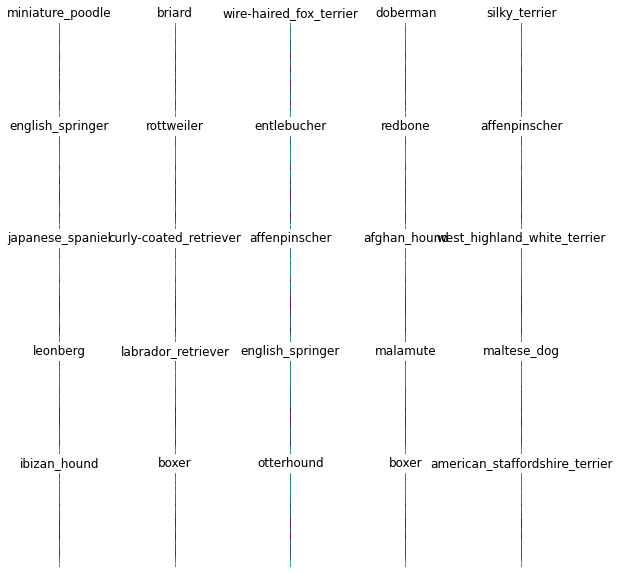

In [0]:
# Now let's visualize the data in a training batch
show_25_images(train_images,train_labels)

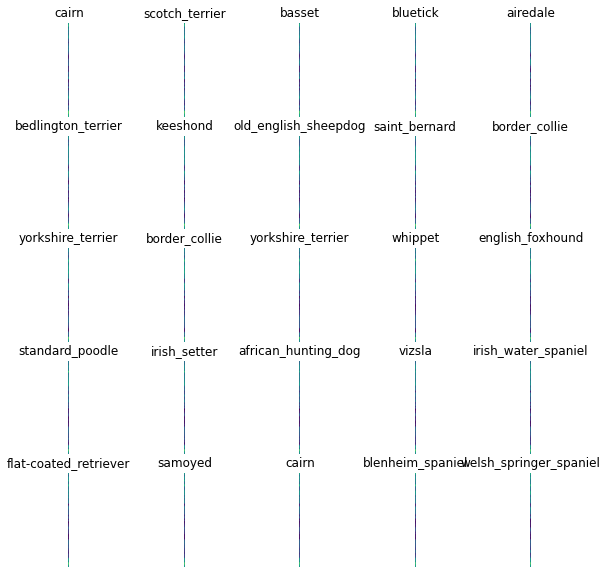

In [0]:
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images,val_labels)

## Building a model

Before we build a model, there are a few things we need to define:
* The input shape (our images shape, in the form of Tensors) to our model
* The output shape(image labels, in the form of Tensors) of our model.
* The URL of the model we want to use from TensorFlow Hub
https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4

In [0]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE,3] # batch, height, width, colour channels
# Setup output of our model
OUTPUT_SHAPE = len(unique_breeds)
# Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

Now we've got our inputs, outputs and model ready to go. 
Let's put them together into a Keras deep learning model!
Knowing this, let's create a function which:
* Takes the input shape, output shape and the model we've chosen as parameters.
* Defines the layers in a Keras model in sequential fashion (do this first, then this, then that).
* Compiles the model (says it should be evaluated and improved).
* Builds the model (tells the model the input shape it'll be getting).
* Returns the model
All of these steps can be found here:
https://www.tensorflow.org/guide/keras/overview

In [0]:
# Create a function which builds a Keras model
def create_model(input_shape = INPUT_SHAPE, output_shape=OUTPUT_SHAPE,model_url = MODEL_URL):
  
  """
  Creates a model using Keras
  """
  
  print('Building model with:', MODEL_URL)

  # Setup the model layers
  model = tf.keras.Sequential([
  hub.KerasLayer(MODEL_URL),# Layer 1 (input layer)
  tf.keras.layers.Dense(units = OUTPUT_SHAPE,
                        activation = "softmax"), # Layer 2 (output layer)
                                
  ])
  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer = tf.keras.optimizers.Adam(),
      metrics = ['accuracy']
  )
  # Build the model
  model.build(INPUT_SHAPE)

  return model

In [0]:
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  5432713   
_________________________________________________________________
dense (Dense)                multiple                  120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


## Creating Callbacks
Callbacks are helper functions a model can use during training to do such things as save its progress, check its progress or stop training early if a model stops improving.
We'll create two callbacks, one for TensorBoard which helps track our models progress and another for early stopping which prevents our model from training for too long.

### TensorBoard Callback
To setup a TensorBoard callback, we need to do three things:
1. Load the TensorBoard notebook extension
2. Create a TensorBoard callback which is able to save logs to a directory and pass it to our model's `fit()` function.
3. Visualize our model traning logs with the `%tensorboard` magic function (we'll do this after model training.)


In [0]:
# Load TensorBoard notebook extension
%load_ext tensorboard

In [0]:
import datetime

# Create a function to build a TensorBoard callback

def create_tensorboard_callback():
  # Create a log directory to store TensorBoard logs
  logdir = os.path.join('drive/My Drive/Colab Notebooks/data/logs',
                        # Make it so the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)




### Early Stopping Callback

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

Early stopping helps stop our model from overfitting if a certaing evaluation metric stops improving

In [0]:
# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience = 3)


## Training a model (on a subset of data)

Our first model is only going to train on 1000 images, to make sure everything is working.

In [0]:
NUM_EPOCHS = 100 #@param {type:"slider",min:10,step:10}


In [0]:
# Check to make sure we're still running on a GPU
print("GPU","available(YESS!!!!)"if tf.config.list_logical_devices("GPU") else "not available :(" )

GPU available(YESS!!!!)


Let's create a function which trains a model.

* Create a model using `create_model()`
* Setup a TensorBoard callback using `create_tensorboard_callback()`
* Call the `fit()` function on our model passing it the training data, validation data, number of epochs to train for (`NUM_EPOCHS`) and the callbacks we'd like to use
* Return the model

In [0]:
# Build a function to train and return a trained model
def train_model():
  """
  Trains a given model and returns the trained version.
  """
  # Create a model
  model = create_model()

  # Create a new TensorBoard session everytime we train a model
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data passing it the callbacks we created

  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1,
            callbacks=[tensorboard,early_stopping])
  # Return the fitted model
  return model


In [0]:
model = train_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Epoch 1/100
25/25 [==============================] - 3s 133ms/step - loss: 4.6152 - accuracy: 0.1013 - val_loss: 3.6397 - val_accuracy: 0.2500
Epoch 2/100
25/25 [==============================] - 3s 110ms/step - loss: 1.6537 - accuracy: 0.6812 - val_loss: 2.3022 - val_accuracy: 0.5150
Epoch 3/100
25/25 [==============================] - 3s 111ms/step - loss: 0.5906 - accuracy: 0.9262 - val_loss: 1.7861 - val_accuracy: 0.5950
Epoch 4/100
25/25 [==============================] - 3s 111ms/step - loss: 0.2624 - accuracy: 0.9837 - val_loss: 1.5705 - val_accuracy: 0.6250
Epoch 5/100
25/25 [==============================] - 3s 111ms/step - loss: 0.1508 - accuracy: 0.9987 - val_loss: 1.4501 - val_accuracy: 0.6350
Epoch 6/100
25/25 [==============================] - 3s 113ms/step - loss: 0.1014 - accuracy: 1.0000 - val_loss: 1.4131 - val_accuracy: 0.6400
Epoch 7/100
25/25 [==============================

### Checking the TensorBoard logs

The TensorBoard magic function (`%tensorboard)` will access the logs directory we created earlier and visualize its contents.

In [0]:
%tensorboard --logdir /content/drive/My\ Drive/Colab\ Notebooks/data/logs

<IPython.core.display.Javascript object>

## Making and evaluating predictions using a trained model

In [0]:
# Make predictions on the validation data (not used to train on)
predictions = model.predict(val_data,verbose=1)
predictions

7/7 [==============================] - 1s 74ms/step


array([[3.3588784e-03, 1.8375819e-04, 1.1506792e-03, ..., 6.5621996e-04,
        1.3825681e-05, 3.5047731e-03],
       [1.5894105e-03, 3.2790913e-04, 9.0758866e-03, ..., 5.4910698e-04,
        6.9235981e-04, 7.0526068e-05],
       [1.2473131e-05, 4.4225431e-05, 5.3599706e-05, ..., 5.4800610e-05,
        1.2150490e-04, 6.0113211e-04],
       ...,
       [2.3682871e-05, 3.9354531e-05, 1.1078718e-04, ..., 1.6880811e-05,
        2.3246995e-04, 3.7775815e-05],
       [1.9319024e-03, 3.0497758e-04, 1.7772753e-04, ..., 1.6695805e-04,
        2.2586688e-05, 1.2006690e-02],
       [2.7827843e-04, 4.1623069e-05, 1.6856435e-04, ..., 3.9838138e-03,
        6.0782151e-04, 7.2164032e-05]], dtype=float32)

In [0]:
np.sum(predictions[0])

1.0

In [0]:
# First prediction 
index = 42
print(predictions[index])
print(f"Max value (probability of prediction): {np.max(predictions[index])}")
print(f"Sum:{np.sum(predictions[index])} ")
print(f"Max index: {np.argmax(predictions[index])}")
print(f"Prediction label: {unique_breeds[np.argmax(predictions[index])]}")

[1.16919386e-04 1.26943472e-04 4.26105134e-06 6.88127466e-06
 1.40879198e-03 3.92278307e-05 4.07646148e-04 1.61235381e-04
 6.13098964e-03 3.27285603e-02 1.78588016e-05 3.32112540e-06
 2.14906424e-04 6.07260363e-03 8.84384732e-04 4.29584365e-03
 2.34022609e-05 5.11266444e-05 2.45470845e-04 1.31809633e-04
 1.52851626e-05 3.34776560e-05 1.38402713e-04 1.44670848e-04
 5.78198256e-03 1.29876920e-04 6.48491505e-06 3.11527510e-05
 7.51547341e-05 2.71108765e-05 1.50341884e-05 3.75496238e-05
 1.38723908e-05 3.18818129e-05 4.00307617e-05 9.50686990e-06
 1.03621103e-04 1.05402767e-04 2.40543231e-05 1.71831712e-01
 1.87965619e-04 1.80784318e-05 2.20748968e-03 3.75666195e-06
 1.44941529e-04 2.14305401e-05 1.28489468e-04 2.66704476e-04
 6.33743330e-05 1.08107699e-04 1.49566204e-05 7.54326975e-05
 4.38916250e-05 1.68878338e-04 4.43710132e-06 1.92934487e-04
 4.77776375e-05 1.73042263e-05 9.45082502e-06 9.67795313e-06
 7.01677927e-05 6.33378397e-04 3.70536441e-06 4.82795913e-05
 5.66721283e-05 1.300782

Having the above functionality is great but we want to be able to do it at scale.
And it would be even better if we could see the image prediction is being made on!


**Note**: Prediction probabilities are also known as confidence levels(intervals)

In [0]:
# Turn probabilities into their respective label(easier to understand)

def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  return unique_breeds[np.argmax(prediction_probabilities)]


In [0]:
# Get a predicted label based on an array of prediction probabilities
  pred_label = get_pred_label(predictions[0])
  pred_label

'border_terrier'

Now since our validation data is still in a batch dataset, we'll have to turn back to a list in order to make predictions on the validation images and then compare those predictions to the validation labels(true labels).

In [0]:
# Create a function to unbatch a batch dataset
def unbatchify(data):
  """
  Takes a batched dataset of (image,label) Tensors and returns separate arrays
  of images and labels.
  """
  images = []
  labels = []
  # Loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])
  return images, labels


In [0]:
# Unbatchify the validation data
val_images, val_labels = unbatchify(val_data)
val_images[0],val_labels[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.2770141 , 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

Now we've got ways to get:
* Prediction labels
* Validation labels(true labels)
* Validation images

Let's make some function to make these all a bit more visual.
We'll create a function which:
* Takes an array of prediction probabilities, an array of true labels and an array of images and integer.
* Convert the prediction probabilities to a predicted label
* Plot the predicted label, its predicted probability and the true label and the target image on a single plot.

In [0]:
def plot_pred(prediction_probabilities, labels, images,n=1):
  """
  View the prediction, ground truth and image for sample n
  """
  pred_prob,true_label, image = prediction_probabilities[n],labels[n],images[n]
  # Get the pred label
  pred_label=get_pred_label(pred_prob)

  # Plot image and remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change the colour of the title depending on the prediction is right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"

  # Change the plot title to be predicted, probability of predictions and true label

  plt.title("{} {:2.0f}% {}".format(pred_label,
                                    np.max(pred_prob)*100,
                                     true_label),color = color)


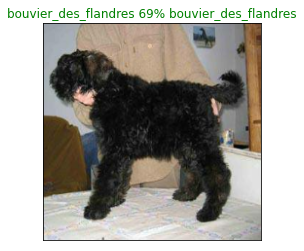

In [0]:
plot_pred(prediction_probabilities=predictions,
          labels=val_labels,
          images=val_images,n=181)

Now we've got one function to visualize our models top prediction, let's make another to view our models top 10 predictions.

This function will:
* Take an input of prediction probabilities
* Find the prediction using `get_pred_label()`
* Find the top 10:
  * Prediction probabilities indexes
  * Prediction probabilities values
  * Prediction labels
* Plot the top 10 prediction probability values and labels, coloring the true label green

In [0]:
 def plot_pred_conf(prediction_probabilities, labels, n=1):
   """
   Plus the top 10
   """
   pred_prob,true_label = prediction_probabilities[n], labels[n]

   # Get the predicted label
   pred_label = get_pred_label(pred_prob)

   # Find the top 10 predictio confidence indexes
   top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
   # Find the top 10 prediction confidence values
   top_10_pred_values = pred_prob[top_10_pred_indexes]
   # Find the top 10 prediction labels
   top_10_pred_labels = unique_breeds[top_10_pred_indexes]

   # Setup plot
   top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                      top_10_pred_values,
                      color = "grey")
   plt.xticks(np.arange(len(top_10_pred_labels)),
              labels = top_10_pred_labels,
              rotation = "vertical")
   
   # Change color of true label
   if np.isin(true_label,top_10_pred_labels):
     top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
   else:
     pass

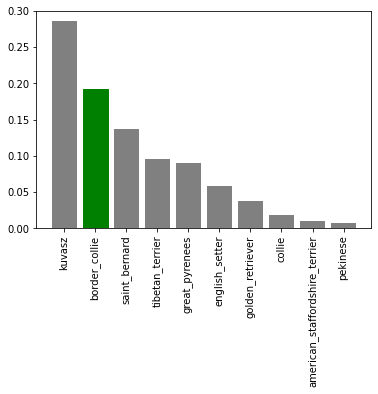

In [0]:
plot_pred_conf(prediction_probabilities=predictions,
               labels=val_labels,
               n=11)

Now we've got some function to help us visualize our predictions and evaluate our model, let's check out a few.


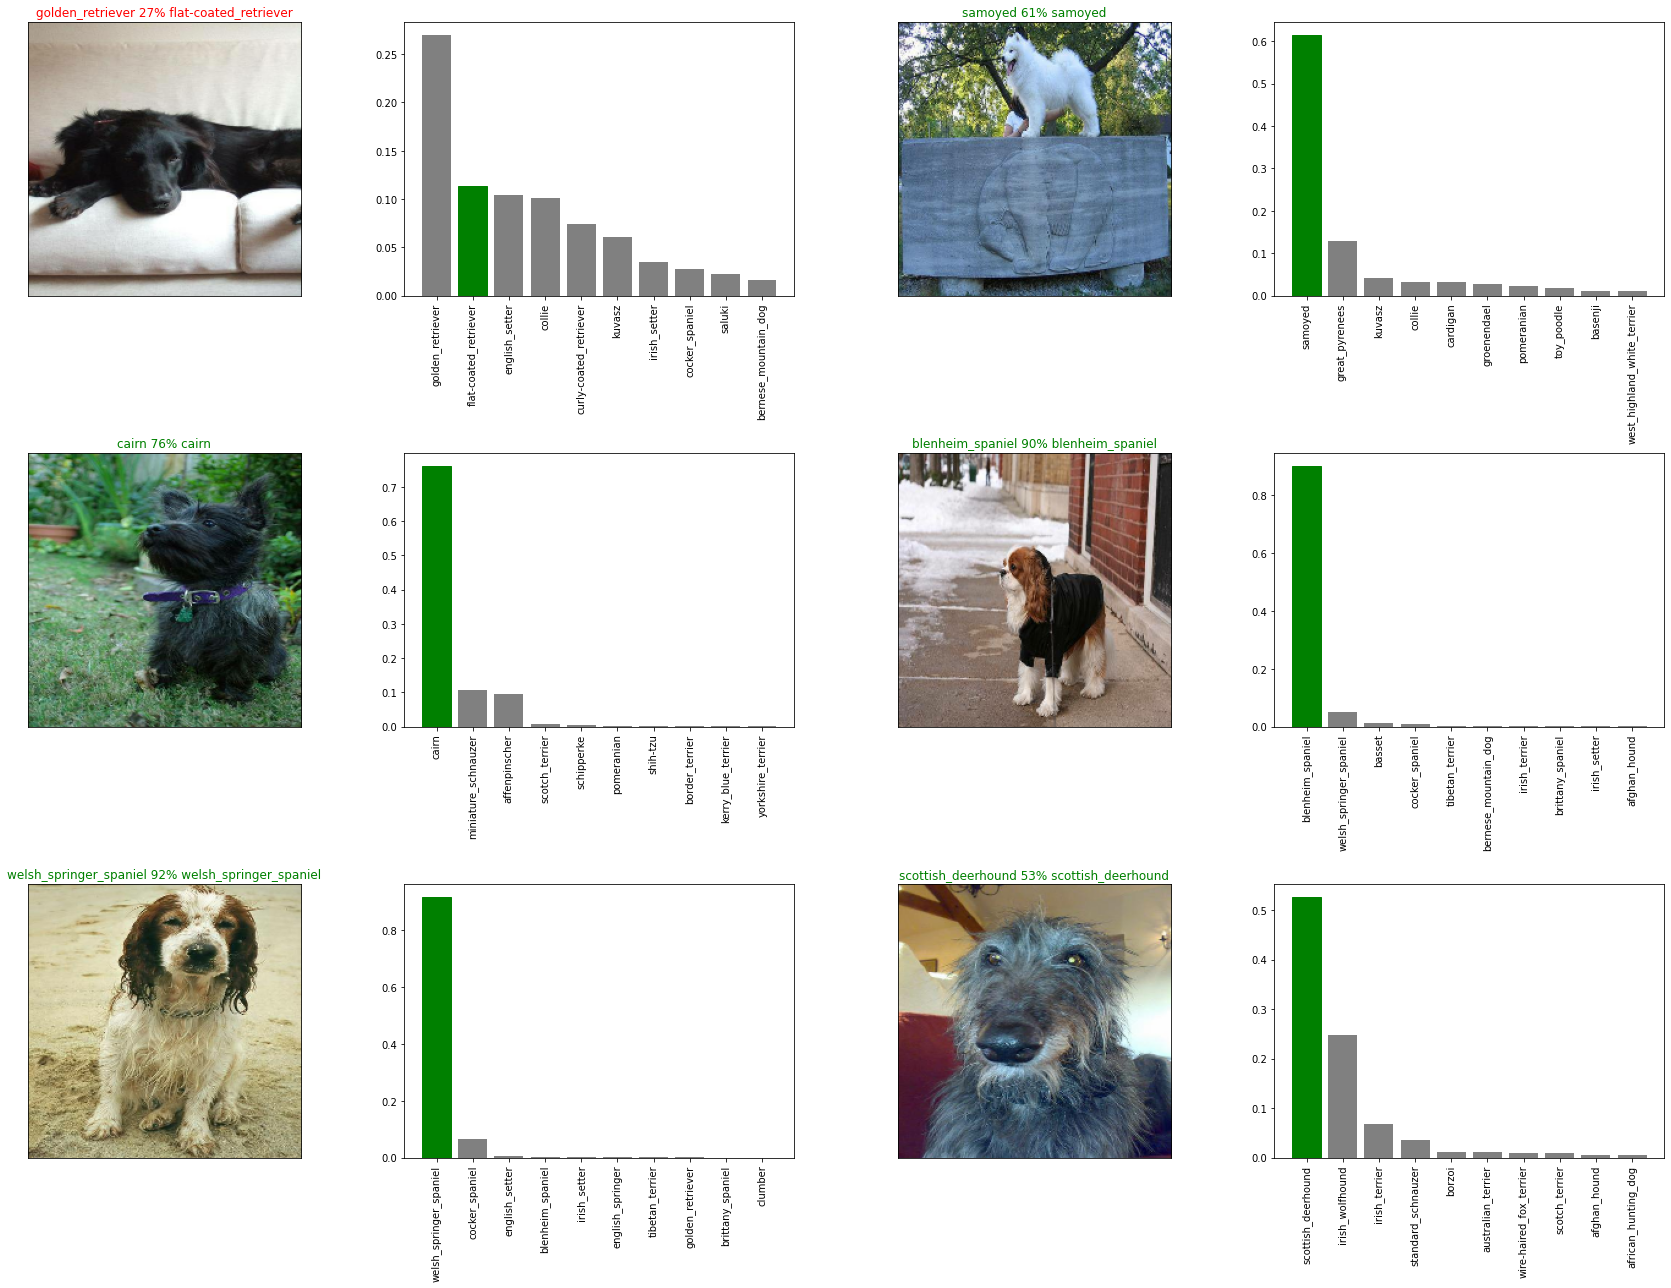

In [0]:
# Let's check out a few predictions and their different values
i_multiplier = 20
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(12*num_cols,6*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols,2*i+1)
  plot_pred(prediction_probabilities=predictions,
            labels = val_labels,
            images = val_images,
            n=i+i_multiplier)
  plt.subplot(num_rows,2*num_cols,2*i+2)
  plot_pred_conf(prediction_probabilities=predictions,
                 labels = val_labels,
                 n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()
  


### Saving and reloading a trained model

In [0]:
# Create a function to save a model
def save_model(model,suffix = None):
  """
  Saves a given model in a models directory and appends a suffix(string).
  """
  # Create a model directory pathname with current time
  modeldir = os.path.join("/content/drive/My Drive/Colab Notebooks/data/models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = modeldir+"-"+suffix+".h5" #save format of model

  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

In [0]:
# Create a function to load a trained model
def load_model(model_path):
  """
  Loads a saved model from specified path.
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects = {"KerasLayer":hub.KerasLayer})
  return model


Now we've got functions to save and load a trained model, let's make sure they work!


In [0]:
# Save our model trained on 1000 images
save_model(model, suffix="1000b-images-mobilenetv2-Adam")

Saving model to: /content/drive/My Drive/Colab Notebooks/data/models/20200328-09181585387111-1000b-images-mobilenetv2-Adam.h5...


'/content/drive/My Drive/Colab Notebooks/data/models/20200328-09181585387111-1000b-images-mobilenetv2-Adam.h5'

In [0]:
# Load a trained model
loaded_1000_image_model = load_model('/content/drive/My Drive/Colab Notebooks/data/models/20200327-11321585308770-1000-images-mobilenetv2-Adam.h5')

Loading saved model from: /content/drive/My Drive/Colab Notebooks/data/models/20200327-11321585308770-1000-images-mobilenetv2-Adam.h5


In [0]:
# Evaluate the pre-saved model
model.evaluate(val_data)

7/7 [==============================] - 1s 87ms/step - loss: 1.3002 - accuracy: 0.6450


[1.300161361694336, 0.6449999809265137]

In [0]:
loaded_1000_image_model.evaluate(val_data)

7/7 [==============================] - 1s 84ms/step - loss: 1.3652 - accuracy: 0.6400


[1.3651751279830933, 0.6399999856948853]

## Training a big dog model (on the full data)

In [0]:
full_data = create_data_batches(X,y)

Creating training data batches...


In [0]:
full_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [0]:
# Create a model for full model
full_model = create_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4


In [0]:
# Create full model callbacks
full_model_tensorboard = create_tensorboard_callback()
# No validation set when training on all the data, so we can't monitor validation accuracy
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                             patience=3)

**Note**: Running the cell below will take a little while(about 30min + for the first epoch) because the GPU we're using in the runtime has to load all of the images into memory.

In [0]:
# Fit the full model to the full data
full_model.fit(x=full_data,
               epochs=NUM_EPOCHS,
               callbacks=[full_model_tensorboard,full_model_early_stopping])

Epoch 1/100
  2/320 [..............................] - ETA: 1:13 - loss: 5.4192 - accuracy: 0.0156WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.205039). Check your callbacks.


320/320 [==============================] - 29s 91ms/step - loss: 1.3259 - accuracy: 0.6702
Epoch 2/100
320/320 [==============================] - 28s 89ms/step - loss: 0.4012 - accuracy: 0.8809
Epoch 3/100
320/320 [==============================] - 28s 89ms/step - loss: 0.2349 - accuracy: 0.9369
Epoch 4/100
320/320 [==============================] - 28s 88ms/step - loss: 0.1553 - accuracy: 0.9617
Epoch 5/100
320/320 [==============================] - 28s 88ms/step - loss: 0.1081 - accuracy: 0.9785
Epoch 6/100
320/320 [==============================] - 28s 89ms/step - loss: 0.0786 - accuracy: 0.9854
Epoch 7/100
320/320 [==============================] - 28s 89ms/step - loss: 0.0587 - accuracy: 0.9923
Epoch 8/100
320/320 [==============================] - 29s 90ms/step - loss: 0.0477 - accuracy: 0.9934
Epoch 9/100
320/320 [==============================] - 29s 89ms/step - loss: 0.0376 - accuracy: 0.9962
Epoch 10/100
320/320 [==============================] - 28s 88ms/step - loss: 0.0318 

In [0]:
save_model(full_model, suffix="full-image-setA-mobilenetv2-Adam")

Saving model to: /content/drive/My Drive/Colab Notebooks/data/models/20200329-08501585471839-full-image-setA-mobilenetv2-Adam.h5...


'/content/drive/My Drive/Colab Notebooks/data/models/20200329-08501585471839-full-image-setA-mobilenetv2-Adam.h5'

In [0]:
# Load the full model
loaded_full_model = load_model('/content/drive/My Drive/Colab Notebooks/data/models/20200329-08501585471839-full-image-setA-mobilenetv2-Adam.h5')

Loading saved model from: /content/drive/My Drive/Colab Notebooks/data/models/20200329-08501585471839-full-image-setA-mobilenetv2-Adam.h5


## Making predictions on the test dataset

Since our model has been trained on images in the form of Tensor batches, to make predictions on the test data, we'll have to get it into the same format.

Luckily we created `create_data_batches()` earlier which can take a list of filenames as input and convert them into Tensor batches.

To make predictions on the test data, we will:
* Get the test filenames.
* Convert the filenames into test data batches using `create_data_batches()` and setting the `test_data` to parameter `True` (since the test data doesn't have labels)
* Make predictions array by passing the test batches to the `predict()` method called on our model.


In [0]:
# Load test image filenames
test_path = "/content/test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]
test_filenames[:10]

['/content/test/bdd1b7cbaa56034c29878e489c57b14a.jpg',
 '/content/test/451e5d09699559f913d6ec5599d6e295.jpg',
 '/content/test/6f7142403a6e6f7a47b763220f883593.jpg',
 '/content/test/4eddf528862bc0a1e5c0c84d5c25cbcd.jpg',
 '/content/test/4927b65015742aa5f7574e3f8d0b4c90.jpg',
 '/content/test/2f14a10ff1ab5435f25b42c3cd7677a7.jpg',
 '/content/test/3ab5ac92251128d0d5f6f5089ce63284.jpg',
 '/content/test/bf0eb0459a247c51af7a201d8cf6b50d.jpg',
 '/content/test/aca4bf7a07f6e9ac27d9a4e0c5c1e68f.jpg',
 '/content/test/38ecc3fe3e67ea1b84f57148e9d0a7b6.jpg']

In [0]:
# Create test data batch
test_data = create_data_batches(test_filenames, test_data=True)

Creating test data batches...


**Note**: Calling `predict()` on our full model and passing in the test data batch will take a fairly long time to run(~1-2hrs)

In [0]:
# Make predictions on test data batch using the loaded full model
test_predictions = loaded_full_model.predict(test_data,
                                             verbose=1)

ERROR! Session/line number was not unique in database. History logging moved to new session 59
324/324 [==============================] - 45s 138ms/step


In [0]:
# Save predictions (NumPy array) to csv file (for access later)
np.savetxt("/content/drive/My Drive/Colab Notebooks/data/predictions/preds_array.csv",
            test_predictions, delimiter=",")


In [0]:
# Load predictions (NumPY array) from csv file
test_predictions = np.loadtxt("/content/drive/My Drive/Colab Notebooks/data/predictions/preds_array.csv",
            delimiter=",")

## Preparig test dataset predictions for Kaggle

Looking at the Kaggle sample submission, we find that it wants our model's prediction probability outputs in a DataFrame with an ID and a column for each different dog breed. https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

To get the data in this format we'll:
* Create a pandas DataFramse with an ID column as well as a column for each dog breed
* Add data to the ID column by extracting the test image ID's from their filepaths.
* Add data (the prediction probabilities) to each of the dog breed columns.
* Export the DataFrame as CSV to submit it to Kaggle.

In [0]:
# Create a pandas DataFrame with empty columns
preds_df = pd.DataFrame(columns=['id']+list(unique_breeds))
preds_df.head()

Empty DataFrame
Columns: [id, affenpinscher, afghan_hound, african_hunting_dog, airedale, american_staffordshire_terrier, appenzeller, australian_terrier, basenji, basset, beagle, bedlington_terrier, bernese_mountain_dog, black-and-tan_coonhound, blenheim_spaniel, bloodhound, bluetick, border_collie, border_terrier, borzoi, boston_bull, bouvier_des_flandres, boxer, brabancon_griffon, briard, brittany_spaniel, bull_mastiff, cairn, cardigan, chesapeake_bay_retriever, chihuahua, chow, clumber, cocker_spaniel, collie, curly-coated_retriever, dandie_dinmont, dhole, dingo, doberman, english_foxhound, english_setter, english_springer, entlebucher, eskimo_dog, flat-coated_retriever, french_bulldog, german_shepherd, german_short-haired_pointer, giant_schnauzer, golden_retriever, gordon_setter, great_dane, great_pyrenees, greater_swiss_mountain_dog, groenendael, ibizan_hound, irish_setter, irish_terrier, irish_water_spaniel, irish_wolfhound, italian_greyhound, japanese_spaniel, keeshond, kelpie, kerry_blue_terrier, komondor, kuvasz, labrador_retriever, lakeland_terrier, leonberg, lhasa, malamute, malinois, maltese_dog, mexican_hairless, miniature_pinscher, miniature_poodle, miniature_schnauzer, newfoundland, norfolk_terrier, norwegian_elkhound, norwich_terrier, old_english_sheepdog, otterhound, papillon, pekinese, pembroke, pomeranian, pug, redbone, rhodesian_ridgeback, rottweiler, saint_bernard, saluki, samoyed, schipperke, scotch_terrier, scottish_deerhound, sealyham_terrier, ...]
Index: []

[0 rows x 121 columns]

In [0]:
# Append test image ID's to predictions DataFrame
test_ids = [os.path.splitext(path)[0] for path in os.listdir(test_path)]

In [0]:
preds_df['id'] = test_ids

ERROR! Session/line number was not unique in database. History logging moved to new session 61


In [0]:
preds_df.head()

id  ... yorkshire_terrier
0  bdd1b7cbaa56034c29878e489c57b14a  ...               NaN
1  451e5d09699559f913d6ec5599d6e295  ...               NaN
2  6f7142403a6e6f7a47b763220f883593  ...               NaN
3  4eddf528862bc0a1e5c0c84d5c25cbcd  ...               NaN
4  4927b65015742aa5f7574e3f8d0b4c90  ...               NaN

[5 rows x 121 columns]

In [0]:
# Add the prediction probabilities to each dog breed column
preds_df[list(unique_breeds)] = test_predictions

In [0]:
# Save our predictions dataframe to CSV for submission to Kaggle
preds_df.to_csv('/content/drive/My Drive/Colab Notebooks/data/predictions/full_model_predictions_submission_1_mobilenetV2.csv',
                index=False)

## Making predictions on custom images, we'll:
* Get the filepaths of our own images
* Turn the filepaths into data batches using 'create_data_batches()`. And since our custom images won't have labels, we set the `test_data` parameter to `True`.
* Pass the custom image data batch to our model's `predict()` method.
* Convert the prediction output probabilities to prediction labels.
* Compare the predicted labrls to the custom images.

In [0]:
# Get custom image filepaths
custom_path = "/content/drive/My Drive/Colab Notebooks/data/my_photos/"
custom_image_paths = [custom_path+fname for fname in os.listdir(custom_path)]

In [0]:
custom_image_paths

['/content/drive/My Drive/Colab Notebooks/data/my_photos/b3c3ed74-62a6-4a8a-8845-b7bda2eb913c.JPG',
 '/content/drive/My Drive/Colab Notebooks/data/my_photos/a6fc811a-4632-42df-b854-503567ad4a4d.JPG',
 '/content/drive/My Drive/Colab Notebooks/data/my_photos/b014b511-d203-4324-a559-d39643eae7fc.JPG',
 '/content/drive/My Drive/Colab Notebooks/data/my_photos/WhatsApp Image 2020-03-28 at 13.08.31.jpeg',
 '/content/drive/My Drive/Colab Notebooks/data/my_photos/WhatsApp Image 2020-03-28 at 13.09.16.jpeg',
 '/content/drive/My Drive/Colab Notebooks/data/my_photos/WhatsApp Image 2020-03-28 at 13.13.14.jpeg',
 '/content/drive/My Drive/Colab Notebooks/data/my_photos/WhatsApp Image 2020-03-28 at 13.13.15 (1).jpeg',
 '/content/drive/My Drive/Colab Notebooks/data/my_photos/WhatsApp Image 2020-03-28 at 13.13.15.jpeg',
 '/content/drive/My Drive/Colab Notebooks/data/my_photos/WhatsApp Image 2020-03-28 at 13.10.06.jpeg',
 '/content/drive/My Drive/Colab Notebooks/data/my_photos/10396a45-3de3-47a2-b999-f36

In [0]:
# Turn custom images into batch dataaset
custom_data = create_data_batches(custom_image_paths,test_data=True)

Creating test data batches...


In [0]:
custom_data

<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

In [0]:
custom_preds = loaded_full_model.predict(custom_data)

In [0]:
custom_preds.shape

(21, 120)

In [0]:
# Get custom image preidiction labels
custom_pred_labels = [get_pred_label(custom_preds[i] for i in range(len(custom_preds)))]
custom_pred_labels 

['affenpinscher']

In [0]:
custom_pred_labels

['affenpinscher']

In [0]:
custom_images = []
# Loop through unbatched data
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

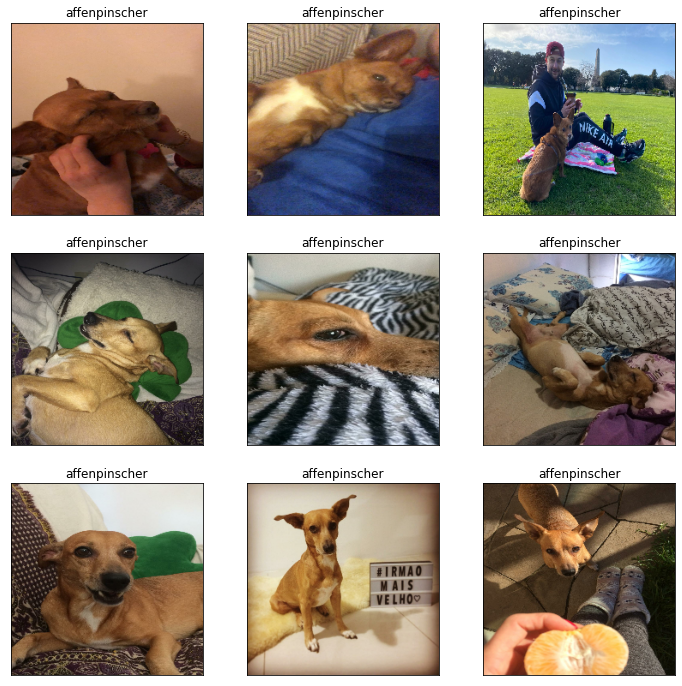

In [0]:
# Check custom image predictions
plt.figure(figsize=(12,12))
for i, image in enumerate(custom_images):
  plt.subplot(3,3,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[0])
  plt.imshow(image)